<html>
<center>
    <div dir = "rtl" style="font-size: 30px; color: black; font-family:verdana">
        <br>
            تمرین کامپیوتری ۳ - 
        <b>
            Naive Bayes Classifier
        </b>
    </div>
<br>
<br>
    <div dir = "rtl" style="font-size: 25px; color: wite;font-family:verdana">
        <b>
            امیرحسین کهربائیان - 
            810199478
        </b>
        <hr>
        <hr>
    </div>
    </center>
</html>

In [1]:
from __future__ import unicode_literals
import hazm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from operator import itemgetter
from sklearn.metrics import classification_report

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
main_test = test.copy()
train.head()

,label,content
0,فناوری,گزارش های منتشر شده حاکی از آن است که کاربران ...
1,ورزشی,سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
2,حوادث,مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
3,فناوری,یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
4,سلامت,دانشمندان در جدیدترین مطالعات خود اثرات جدید و...


<html>
    <div dir = "rtl" style="font-size: 25px; color: red">
        <b>
            فاز اول: پیش‌پردازش داده
        </b>
    </div>
    <div dir = "rtl" style = "font-size: 18px">
        <br>
        ۱.
      در متن هر خبر و مقاله ای ممکن است کلماتی وجود داشته باشند که دارای یک ریشه هستند و شباهت زیادی با هم دارند. به عنوان مثال کلمات قاضی , قضات و قاضی ها درای ریشه یکسان هستند. همچنین در کلمات هم خانواده نیز شباهت زیادی می توان یافت (کبک, کیک, کاک) 
         <br>
        برای تحلیل دقیق تر و به دست آوردن نتایج مناسب تر بهتر است که کلمات مشابه را یکسان کنیم. هدف  
        stemming, lemmatization
        بی اثر کردن تفاوت این کلمات است به صورتی که یک کلمه در نظر گرفته شوند.
        <br>
        در 
        stemming
        کلمات را با ریشه خود جایگزین می کنیم مثلا:
        (likes, liked, liking) -> like.
        <br>
         در 
        lemmatisation
        کلمات مشابه مانند کلمات هم‌خانواده و هم معنی را در یک گروه قرار می‌دهیم و یک کلمه در نظر می گیریم. همانطور که در بخش های بعد خواهید دید به کمک 
        lemmatisation
        بخش های اضافی کلمات (پپیش وند ها ,نشانه های جمع و ...) را حذف می کنیم.
        <br>
    </div>
</html>

<html>
    <div dir = "rtl" style = "font-size: 17px; color: blue">
        <b>
            در این قسمت توابع مختلف برای عملیات های مختلفی که در بخش پیش پردازش داده استفاده می شود را تعریف می  کنیم :
        </b>
    </div>
    <div dir = "rtl" style = "font-size: 18px">
        <br>
        ۱) 
        عملیات 
        normalized
        کردن داده ها را برای از بین بردن فاصله و نیم فاصله ها به کمک کتابخوانه 
        hazm
        انجام می دهیم. <br>
        2) 
        متن را به کلمات درونش تجزیه می کنیم.<br>
        ۳) 
        کلمات پر تکرار و کلماتی که در تحلیل داده ها به ما کمکی نمی کنند را از متن حذف می کنیم.
<br>
        4) 
                همانطور که در بالا گفته شد فرآیند
        lemmatization
        را انجام میدهیم.
        <br>
    </div>
</html>

In [3]:
special_characters = {'~', '،', ':', "'", '+', '[', '\\', '@','؛', '»', '«' ,'^', '{', '%','–', '(', '-', '"', '*',"", '|', ',', '&', '<', '`', '}', '.', '_', '=', ']', '!', '>', ';', '?', '#', '$', ')', '/', '<<', '>>'}
stop_words_set = set(hazm.stopwords_list()).union(special_characters)

def get_normalized_data(data):
    normalizer = hazm.Normalizer()
    lemmatizer = hazm.Lemmatizer()
    
    for index, row in data.iterrows():
        row[1] = normalizer.normalize(row[1])
        row[1] = hazm.word_tokenize(row[1])
        row[1] = [word for word in row[1] if (word not in stop_words_set and not(word.isdigit()))]
        for word in row[1]:
            word = lemmatizer.lemmatize(word).split('#')[0]
    return data
    


train = get_normalized_data(train)
test = get_normalized_data(test)

<html>
    <div dir = "rtl" style="font-size: 25px; color: red">
        <b>
            فاز دوم: فرآیند مسئله
        </b>
    </div>
    <div dir = "rtl" style = "font-size: 16px">
        <br>
        2.
        $$ P(c|x) = \frac{P(x|c)P(c)}{P(x)} $$
        <br>
        x: کلمات دیده شده در متن خبر 
        <br>
        c: دسته بندی خبر
        <br>
        <br>
        $P(c | x)$ : (Posterior Probability)
احتمال اینکه دسته بندی خبر 
        c
        باشد با شرط این که در متن خبر کلمه 
        x
        وجود داشته باشد.
        <br>
        روش محاسبه:
طبق فرمول با توجه به محاسبات سمت راست تساوی به دست می آید. در ادامه به طور دقیق این موضوع بررسی می شود.
        <br>
        <br>
        $P(x | c)$: (Likelihood)
        احتمال دیده شدن  
        x
        به شرط اینکه موضوع خبر 
        c
        باشد.
        <br>
        روش محاسبه:
        تعداد کل کلمه های خبر های با دسته بندی 
        c
        را در مخرج گذاشته و میزان تکرار کلمه 
        x
        را در این خبر ها در صورت گذاشته و بدین صورت مقدار خواسته شده به دست می آید.
        <br>
        <br>
        $P(c)$: (Class Prior Probablity)
        احتمال اینکه موضوع خبر با توجه به مشاهداتی که تا الان انجام شده است، 
        c
        باشد.
        <br>
        روش محاسبه:
        با تقسیم تعداد خبر ها با دسته بندی 
        c
        به تعداد کل خبر ها این مقدار به دست می آید.
با توجه به این که در ابتدای پروژه گفته شده است از هر دسته بندی تعداد برابری خبر وجود دارد، در این شرایط این مقدار برابر 
        $\frac{1}{6}$
        است.
        <br>
        <br>
        $P(x)$: (Predictor Prior Probablity)
        احتمال اینکه 
        x
        دیده شود.
        <br>
        روش محاسبه:
میزان تکرار کلمه 
        x
        در تمامی خبر ها را تقسیم بر تعداد کل کلمات می کنیم.
        <br> <br><b>
        لازم به ذکر است توضیحات تکمیلی دیگر این بخش در فاز سوم (ارزیابی) گفته می شود.
        </b>
        <br>
    </div>
</html>

<html>
    <div dir = "rtl" style = "font-size: 16px; color : blue">
        برای به دست آوردن مقدار های اشاره شده نیاز به متغیر های زیر داریم :
    </div>
</html>

In [4]:
titles = dict() # title : num of news that has this title
num_words_in_title = dict() # (title, word) -> how many??
all_words_in_title = dict() # title -> num of all word
words_in_data = dict()
num_of_all_words, unique_words, visit_words = 0, 0, set()

In [5]:
def get_titles(data) :
    for index, news in data.iterrows():
        if news[0] in titles.keys() :
            titles[news[0]] += 1
        else :
            titles[news[0]] = 1
    return 
    
def calc_amounts(data, titles : dict, num_words_in_title : dict, all_words_in_title, words_in_data : dict,
                 num_of_all_words : int, unique_words : int, visit_words : dict) :
    
    get_titles(data)
    for title in titles.keys():
        num_words_in_title[title] = dict()
        all_words_in_title[title] = 0
    
    for index, title_and_news in data.iterrows():
        title, news = title_and_news[0], title_and_news[1]
        for token in news :
            num_of_all_words += 1
            all_words_in_title[title] += 1
            
            if token not in visit_words:
                visit_words.add(token)
                unique_words += 1
            
            if token in words_in_data.keys() :
                words_in_data[token] += 1
            else :
                words_in_data[token] = 1
            
            if token in num_words_in_title[title].keys() :
                num_words_in_title[title][token] += 1
            else :
                num_words_in_title[title][token] = 1
    
calc_amounts(train, titles, num_words_in_title, all_words_in_title, words_in_data, num_of_all_words
             ,unique_words, visit_words)


<html>
    <div dir = "rtl" style="font-size: 23px; color: red">
        <b>
            Bigrams
        </b>
    </div>
</html>

<html>
    <div dir = "rtl" style = "font-size: 16px">
       3)<br>
        <b>
        شانه ام درد می کند.
        <br>
        شانه موهایم را باید عوض کنم.
        </b>
        <br>
        در این مثال کلمه بعد از شانه معنی آن را مشخص می کند. در مثال اول با توجه به کلمه (درد) متوجه می شویم منظور از (شانه) عضوی از بدن است که به درد آمده است ولی در مثال دوم با توجه به کلمه (مو) می فهمیم منظور از (شانه) وسیله مرتب کردن موهاست.
        <br>
        در این مثال 
        bigram
        برای فهمیدن معنای کلمه کافی بود و نیاز به 
        n-gram
        طولانی تر نداریم .
        <br>
    </div>
</html>

<html>
    <div dir = "rtl" style="font-size: 23px; color: red">
        <b>
            Additive Smoothing
        </b>
    </div>
    <div dir = "rtl" style = "font-size: 16px">
        <br>
        4.
        در قسمت های قبل فرمول زیر تشریح شد :
        $$ P(c|x) = \frac{P(x|c)P(c)}{P(x)} $$
        در صورتی که 
        x
        در 
        c
        یافت نشود
        $P(x | c) = 0$
         در نتیجه
        $P(c|x)$
        نیز برابر 0 می‌شود. پس در این مدل با قطعیت تشخیص می‌دهیم که موضوع مورد نظر 
        c
        نیست.
        <br>
        پس اگر 
        x
        فقط در یک موضوع خاص مانند 
        A
        وجود داشته باشد، با توجه به این که در این مدل 
        $p(c | x)$
        به ازای تمام موضوعات دیگر برابر 0 است 
        مدل با قاطعیت تشخیص می‌دهد هر مقاله ای که در آن کلمه 
        x
        آمده، موضوعش 
        A
        است.
        <hr>
    </div>
</html
>


<html>
    <div dir = "rtl" style = "font-size: 16px">
        <br>
        5.
        اگر فرض کنید تعداد کل کلماتی که در مقاله هایی با موضوع 
        c
        آمده است برابر با $ N(c) $
        است ، 
        گفته شد که :
        <br> <br>
        $$ P(x|c) = \frac{Count(x,c)}{N(c)} $$
        <br>
        حال برای حل مشکلی که ذکر شده بود فرمول را اینگونه تغییر می دهیم : <br><br>
        $$ P(x|c) = \frac{Count(x,c)+a}{N(c)+UniqueWords} $$ <br>
        در این فرمول  $ a $ یک عدد صحیح مثبت است.
        در این حالت اگر 
        x
        در متن خبر با موضوع
        c
        نیامده باشد ،
        $ P(x|c) $
        دیگر صفر نمی شود و مشکلی که گفته شده بود رفع می شود.
    </div>
</html
>


<html>
    <div dir = "rtl" style="font-size: 23px; color: red">
        <b>
            بررسی صحت
        </b>
    </div>

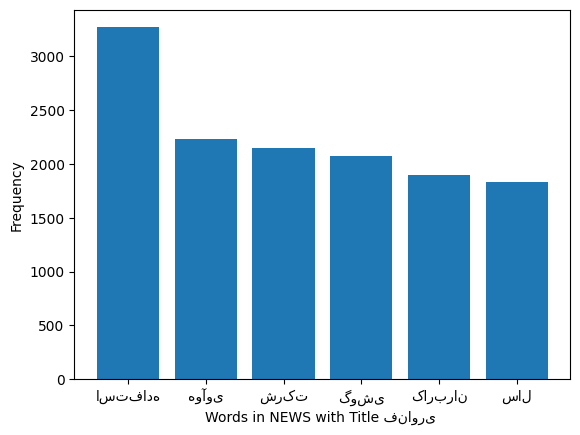

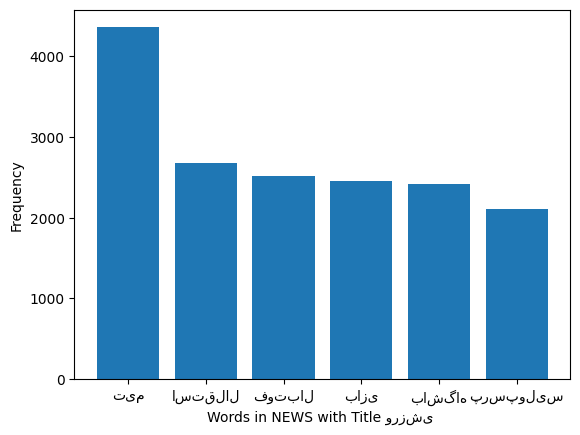

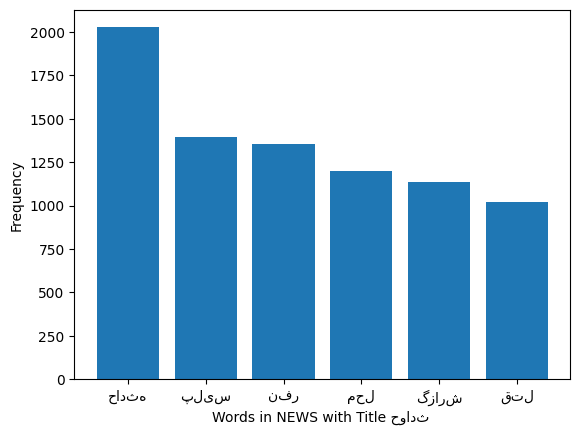

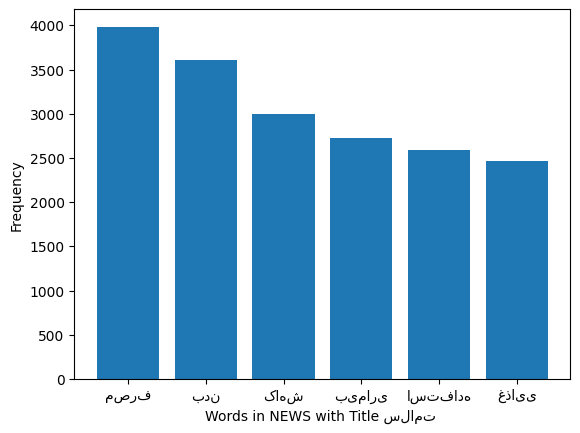

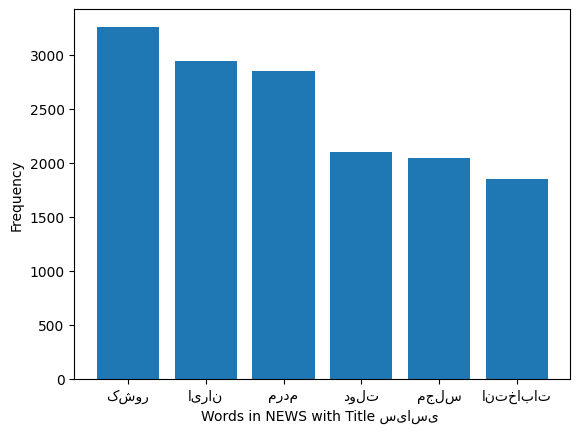

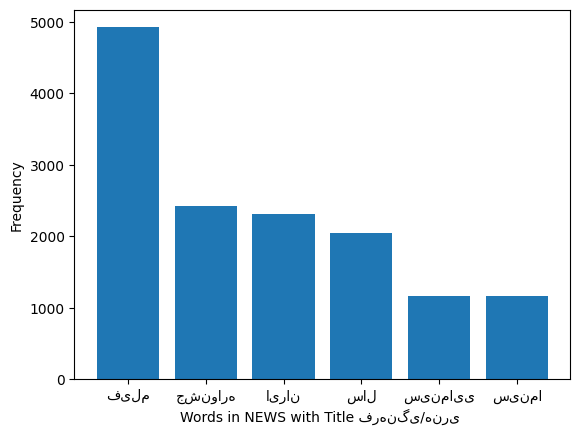

In [6]:
def plot_chart(title):
    sorted_dict = dict(sorted(num_words_in_title[title].items(), key=itemgetter(1), reverse=True)[:6])
    plt.bar(sorted_dict.keys(), sorted_dict.values())
    plt.xlabel(f"Words in NEWS with Title {title} ")
    plt.ylabel("Frequency")
    plt.show()
    
for i in range(len(titles)) :
    plot_chart((list(titles.keys()))[i])
    

<html>
    <div dir = "rtl" style="font-size: 25px; color: red">
        <b>
            فاز سوم : ارزیابی
        </b>
    </div>

<html>
    <div dir = "rtl" style = "font-size: 16px">
        <br>
        همانطور که می دانیم برای حل این مسئله از مدل 
        bagof words
        استفاده کنیم. در این مدل هر کلمه مستقل از جایگاهش در نظر گرفته می شود و تعداد تکرار هر کلمه در هر دسته بندی 
        feature
        محسوب می شود.<br>
        در 
        Naive Bayes
        نوع دسته بندی را پدر تمام 
        feature
        ها در نظر می  گیریم و فرض می کنیم که فرزندانش به شرط دانستن پدر از یکدیگر مستقل هستند. بنابراین اگر کلمات استفاده شده در خبر را 
        X
        در نظر بگیریم، باید 
        $$ P(c|X) = P(c) * P(x_{1}|c) * P(x_{2}|c) * P(x_{3}|c) * ... $$
        را به ازای 
        c
        های مختلف به دست آوریم( منظور از 
        c
        های مختلف، دسته بندی های مختلف است.) روش محاسبه $P(x_{1}|c)$ نیز در قسمت قبل توضیح داده شد.
        <br>
        با توجه به این که حاصل ضرب احتمال ها در هم ممکن است مقدار بسیار کوچکی شود و خطا در محسابات زیاد شود از لگاریتم استفاده می کنیم. فقط باید توجه داشته باشیم که با توجه به قوانین لگاریتم، به جای ضرب عبارات، لگاریتم آن ها را جمع می کنیم.
    </div>
</html
>


In [7]:
def calculate_probs(tokens : list, num_all_news : int, alpha):
    probability = dict()
    for news_title, num_title in titles.items():
        probability[news_title] = np.log(num_title / num_all_news) # calc P(c)

    for token in tokens:
        for title, value in titles.items():
            if token not in num_words_in_title[title].keys():
                num_words_in_title[title][token] = 0
            
            probability[title] += np.log((num_words_in_title[title][token] + alpha ) / (all_words_in_title[title] + ((alpha) * unique_words)))
    return probability

def estimate_title_news(news : list, num_all_news : int, alpha):
    probability = calculate_probs(news, num_all_news , alpha)
    final_title, max_p = (list(titles.keys()))[0], -float("inf")
    
    for title, prob in probability.items():
        if prob > max_p :
            final_title = title
            max_p = prob
    return final_title    

<html>
    <div dir = "rtl" style = "font-size: 18px">
        7) 
        Precision :
        با توجه به تعریف در این معیار ما به خبرهایی که این دسته بندی را داشته اند ولی ما به اشتباه یک دسته بندی دیگر را پیش بینی کرده ایم نداریم.
به عنوان مثال فرض کنید 
        500
        خبر داریم که از میان آن ها 
        200
        خبر مربوط به دسته بندی سیاسی است. اگر تشخیص ما این باشد که 5 خبر سیاسی داریم(خطای زیادی در تشخیص وحود دارد)  میزان این متغیر برابر با
          $\frac{5}{5} = ۱$
        می شود. در واقع با این که میزان خطا زیاد بود ولی مقدار متغیر عدد 
        ۱
        شد که این مقدار زیادی است.
        ( بی توجهی به 
        False Negative
        )
        <br> <hr>
        Recall :
        مشکل این معیار برعکس معیار قبلی است. در این معیار توجهی به خبر هایی که این موضوع را نداشتند و به اشتباه تشخیص داده ایم که این موضوع را دارند نمی شود.
        مثلا اگر تشخیص ما این باشد که تمام خبر ها سیاسی هستند واضح است که خطای بسیار زیادی وجود دارد ولی مقدار این متغیر برابر با 
        1
        می شود که با توجه به بالا بودن خطا این مقدار مناسب نیست.
         ( بی توجهی به 
        False Positive
        )
    </div> 
</html>

<html>
    <div dir = "rtl" style = "font-size: 18px">
        8)
این معیار از میانیگن 
        harmonic
        دو معیار بالا استفاده کرده است.
        میانگین عادی زمانی مناسب است که هزینه بد بودن دو معیار بالا یکسان باشد ولی در صورتی که عیب دو معیار بالا هزینه های متفاوتی برای ما ایجاد کند استفاده از این نوع میاگین مناسب تر و دقیق تر است و برای همین در اینجا بهتر است که از این نوع میانگین استفاده کنیم.   
    </div> 
</html>

<html>
    <div dir = "rtl" style = "font-size: 18px">
        ۹)
این معیار از میانیگن 
        Macro :
        Macro-averaged F1-score 
        یا به اختصار 
        Macro-F1
        از معیار 
        F1-score
        در میانگین گیری از تمامی کلاس ها استفاده می کند.
        همچنین می توان
        Macro-averaged Presicion
        را نام برد که از معیار 
         Presicion 
        در میانگین گیری کلاس ها استفاده می کند.<br><hr>
        Weighted:
        در معیار قبل ما در میانگین گیری وزن یکسانی به 
        F1
        تمام دسته ها می دهیم اما در این معیار به
        F1 score
        هر دسته وزنی متناسب با دیتای موجود در رابطه با آن دسته می دهیم. به طور مشابه می توان 
        Weighted-precision
        یا
         Weighted-recall
        را نیز تعریف کرد. <br><hr>
        Micro :
        در این معیار از 
         Accuracy
        استفاده می شود. <br>
    </div> 
</html>

<html>
    <div dir = "rtl" style = "font-size: 18px;color:blue">
    اگر 
        alpha
        برابر با 
        عددی غیر از صفر(و صحیح و مثبت) باشد
        به این معناست که از 
        smoothing
        استفاده می کنیم و در غیر این صورت از این روش استفاده نمی کنیم. 
    </div> 
</html>

In [8]:
estimate_titles_with_smoothing = []
estimate_titles_without_smoothing = []

for index, row in test.iterrows():
    estimate_titles_without_smoothing.append(estimate_title_news(row[1],len(test), 0))
    estimate_titles_with_smoothing.append(estimate_title_news(row[1], len(test), 1))
    
test['predicted titles without smoothing'] = estimate_titles_without_smoothing
test['predicted titles with smoothing'] = estimate_titles_with_smoothing
test.head(10)


/tmp/ipykernel_18910/3980444489.py:11: RuntimeWarning: divide by zero encountered in log
  probability[title] += np.log((num_words_in_title[title][token] + alpha ) / (all_words_in_title[title] + ((alpha) * unique_words)))


,label,content,predicted titles without smoothing,predicted titles with smoothing
0,فناوری,"[اعلام, لیست, شرکت, مجاز, ثبت, سفارش, ارائه, خ...",فناوری,فناوری
1,فرهنگی/هنری,"[استاد, علم, قرائت, قرآن, کریم, ریشه, موسیقی, ...",فناوری,فرهنگی/هنری
2,حوادث,"[آتش, سوزی‌های, زنجیره‌ای, جنگل‌های, زاگرس, اس...",فناوری,حوادث
3,فناوری,"[استفاده, سرویس‌های, iMassage, Facetime, محصول...",فناوری,فناوری
4,حوادث,"[دادستان, عمومی, انقلاب, یاسوج, میلیون, دلار, ...",فناوری,حوادث
5,حوادث,"[مردی, اتهام, قتل, تبرئه, مهاجرت, تهران, دست, ...",حوادث,حوادث
6,فناوری,"[شرایط, کنونی, بازار, گوشی, هوشمند, گونه‌ای, ر...",فناوری,فناوری
7,ورزشی,"[شایسته_است, وضعیتی, استاندار, مازندران, مدیرک...",فناوری,ورزشی
8,فناوری,"[کاربران, دنبال, گوشی, میان‌رده, خوش‌قیمتی, بت...",فناوری,فناوری
9,فرهنگی/هنری,"[نشریه, ورایتی, گزارشی, پیش‌بینی, جشنواره, کن,...",فناوری,فرهنگی/هنری


In [9]:
def get_accuracy(main_label, predicted_label):
    true_gues= 0;
    for m, p in zip(main_label, predicted_label):
        true_gues += int(m == p)
    return true_gues / len(main_label)

def get_precision(main_label, predicted_label, label):
    correct_gues = 0
    all_gues = 0
    for m, p in zip(main_label, predicted_label):
        if p == label:
            all_gues += 1
            if m == p:
                correct_gues += 1
                
    return correct_gues / all_gues

def get_recall(main_label, predicted_label, label):
    correct_gues = 0
    in_label = 0
    for m, p in zip(main_label, predicted_label):
        if m == label:
            in_label += 1
            if m == p:
                correct_gues += 1
    return correct_gues / in_label

def get_f1(main_label, predicted_label, label):
    recall = get_recall(main_label, predicted_label, label)
    precision = get_precision(main_label, predicted_label, label)
    if (recall + precision == 0):
        return 0
    return 2 * (recall * precision) / (recall + precision)

def get_macro(main_label, predicted_label):
    f1 = []
    for label, value in titles.items():
        f1.append(get_f1(main_label, predicted_label, label))
    return sum(f1) / len(f1)

def get_weighted(main_label, predicted_label):
    weights = dict()
    f1 = dict()
    
    for label, value in titles.items():
        weights[label] = 0
        f1[label] = (get_f1(main_label, predicted_label, label))
    for label in main_label:
        weights[label] += 1
        
    res = 0
    for label, value in f1.items():
        res += value * weights[label]
    return res / sum(weights.values())

<html>
    <div dir = "rtl" style = "font-size: 16px">
        <br>
        <b>
        ۱۰ )
        الف
        </b>
            <br>
    </div>
</html>

In [10]:
Table, col_name, none = [], ["SCALE"], " ---- "
title_EN = ["Health", "Political", "Sports", "Technology", "Art", "Accidents"]
title_FA = list(titles.keys())
col_name += title_EN + ["All‬‬ ‫‪Classes"]

main_label = test.loc[:, 'label']


recall, precision, F1_score = ["Recall"], ["Precision"], ["F1-score"]

for title in title_FA:
    recall.append(get_recall(main_label, estimate_titles_without_smoothing, title))
    precision.append(get_precision(main_label, estimate_titles_without_smoothing, title))
    F1_score.append(get_f1(main_label, estimate_titles_without_smoothing, title))
    
recall.append(none)
precision.append(none)
F1_score.append(none)

Table.append(recall)
Table.append(precision)
Table.append(F1_score)

micro = ['Micro Avg'] + 6*[none] + [get_accuracy(main_label, estimate_titles_without_smoothing)]
accuracy = ['Accuracy'] + 6*[none] + [get_accuracy(main_label, estimate_titles_without_smoothing)]
macro = ['Macro Avg'] + 6*[none] + [get_macro(main_label, estimate_titles_without_smoothing)]
weighted = ['Weighted Avg'] + 6*[none] + [get_weighted(main_label, estimate_titles_without_smoothing)]

Table.append(accuracy)
Table.append(macro)
Table.append(micro)
Table.append(weighted)

pd.DataFrame(Table, columns = col_name)

,SCALE,Health,Political,Sports,Technology,Art,Accidents,All‬‬ ‫‪Classes
0,Recall,0.994048,0.184211,0.095,0.107345,0.205,0.166667,----
1,Precision,0.176346,0.972222,0.791667,0.95,0.854167,0.75,----
2,F1-score,0.299552,0.309735,0.169643,0.192893,0.330645,0.272727,----
3,Accuracy,----,----,----,----,----,----,0.278924
4,Macro Avg,----,----,----,----,----,----,0.262532
5,Micro Avg,----,----,----,----,----,----,0.278924
6,Weighted Avg,----,----,----,----,----,----,0.2623


In [11]:
CA_without = classification_report(y_true = main_label, y_pred=estimate_titles_without_smoothing, output_dict=True)
pd.DataFrame(data=CA_without).T

,precision,recall,f1-score,support
حوادث,0.791667,0.095000,0.169643,200.000000
سلامت,0.950000,0.107345,0.192893,177.000000
سیاسی,0.854167,0.205000,0.330645,200.000000
فرهنگی/هنری,0.750000,0.166667,0.272727,180.000000
فناوری,0.176346,0.994048,0.299552,168.000000
ورزشی,0.972222,0.184211,0.309735,190.000000
accuracy,0.278924,0.278924,0.278924,0.278924
macro avg,0.749067,0.292045,0.262532,1115.000000
weighted avg,0.759341,0.278924,0.262300,1115.000000


<html>
    <div dir = "rtl" style = "font-size: 16px">
        <hr>
        <br>
        <b>
        ۱۰ )
        ب
        </b>
            <br>
    </div>
</html>

In [12]:
Table, col_name, none = [], ["SCALE"], " ---- "
title_EN = ["Health", "Political", "Sports", "Technology", "Art", "Accidents"]
title_FA = list(titles.keys())
col_name += title_EN + ["All‬‬ ‫‪Classes"]

main_label = test.loc[:, 'label']


recall, precision, F1_score = ["Recall"], ["Precision"], ["F1-score"]

for title in title_FA:
    recall.append(get_recall(main_label, estimate_titles_with_smoothing, title))
    precision.append(get_precision(main_label, estimate_titles_with_smoothing, title))
    F1_score.append(get_f1(main_label, estimate_titles_with_smoothing, title))
    
recall.append(none)
precision.append(none)
F1_score.append(none)

Table.append(recall)
Table.append(precision)
Table.append(F1_score)

micro = ['Micro Avg'] + 6*[none] + [get_accuracy(main_label, estimate_titles_with_smoothing)]
accuracy = ['Accuracy'] + 6*[none] + [get_accuracy(main_label, estimate_titles_with_smoothing)]
macro = ['Macro Avg'] + 6*[none] + [get_macro(main_label, estimate_titles_with_smoothing)]
weighted = ['Weighted Avg'] + 6*[none] + [get_weighted(main_label, estimate_titles_with_smoothing)]

Table.append(accuracy)
Table.append(macro)
Table.append(micro)
Table.append(weighted)

pd.DataFrame(Table, columns = col_name)

,SCALE,Health,Political,Sports,Technology,Art,Accidents,All‬‬ ‫‪Classes
0,Recall,0.928571,0.973684,0.965,0.943503,0.96,0.872222,----
1,Precision,0.962963,0.984043,0.901869,0.976608,0.880734,0.969136,----
2,F1-score,0.945455,0.978836,0.932367,0.95977,0.91866,0.918129,----
3,Accuracy,----,----,----,----,----,----,0.941704
4,Macro Avg,----,----,----,----,----,----,0.942203
5,Micro Avg,----,----,----,----,----,----,0.941704
6,Weighted Avg,----,----,----,----,----,----,0.94185


In [13]:
CA_with = classification_report(y_true = main_label, y_pred=estimate_titles_with_smoothing, output_dict=True)
pd.DataFrame(data=CA_with).T

,precision,recall,f1-score,support
حوادث,0.901869,0.965000,0.932367,200.000000
سلامت,0.976608,0.943503,0.959770,177.000000
سیاسی,0.880734,0.960000,0.918660,200.000000
فرهنگی/هنری,0.969136,0.872222,0.918129,180.000000
فناوری,0.962963,0.928571,0.945455,168.000000
ورزشی,0.984043,0.973684,0.978836,190.000000
accuracy,0.941704,0.941704,0.941704,0.941704
macro avg,0.945892,0.940497,0.942203,1115.000000
weighted avg,0.944009,0.941704,0.941850,1115.000000


<html>
    <div dir = "rtl" style = "font-size: 16px">
        <br>
        <hr>
        11)
        همانطور که مشاهده می کنیم استفاده از 
        Additive Smoothing
        می تواند تاثیر بسیار زیادی در افزایش دقت داشته باشد که دلیل آن در سوال ۵ به طور دقیق گفته شده است.
        <br>
    </div>
</html>

In [14]:
count = 0
for index, lable_news in test.iterrows():
    if count == 5:
        break

    if lable_news[0] != lable_news[3]:
        print(f'\n**********************\nNews Number {count+1}')
        print(f'Main Title: {lable_news[0]}')
        print(f'Estimate Title: {lable_news[3]}')
        print(main_test["content"][index])
        
        count += 1



**********************
News Number 1
Main Title: فرهنگی/هنری
Estimate Title: سیاسی
- چهارشنبه اول تیر 1401 اتفاق نادر و جالبی رخ داد که قطعا به صورت تصادفی و بدون برنامه‌ریزی و اطلاع قبلی بوده است: این که به شکل کاملا هم‌زمان در محل انجمن صنفی روزنامه‌نگاران استان تهران از رونمایی شد و در صدا‌و‌سیما و در جمع معاونان سازمان هم از کلیات « ».   اگرچه سه واژۀ در هر دو مشترک‌اند اما هیچ ربط و شباهتی به هم ندارند. چرا که در اولی منظور از سند است و در دومی سند (در حالی که به تعبیر دکتر وب‌2 را هم پشت سر گذاشته و به زودی وارد وب‌3 خواهیم شد) و خود رادیو و تلویزیون دیگر رسانۀ مدرن نیست و به تعبیری رسانۀ تلویزیون در معنی عام و جهانی نه مشخصا صدا و سیما هر چند در ایران همچنان رایگان‌ترین و گسترده‌ترین امکان وقت‌گذرانی و ارتباطی است. (رایگان از جهت پرداخت حق اشتراک وگرنه بودجۀ آن از جیب ملت تأمین می‌شود). در اولی منظور از رسانه واقعا رسانه است. یعنی بدون بودجۀ حکومتی و مخاطب‌محور و در دومی به جز تعبیر «رسانه ملی» در باقی موارد ترجیح می‌دهند از مفاهیم ایدیولوژیک استفاده کنند و آن را در واقع عرصۀ ج

<html>
    <div dir = "rtl" style = "font-size: 16px; color : blue">
        <br>
        12)
        در این مدل ما فقط به وجود کلمه توجه می کنیم و به بافت متن و کلمه های اطراف آن توجهی نمی کنیم که این موضوع دقت پیش بینی ما را کاهش میدهد.  
    </div>
    <div dir = "rtl" style = "font-size: 70px; color : red">
        <br>
        <center>
            پایان
         </center>
        <br><hr><hr>
    </div>
</html>
